In [1]:
import os
import math
import subprocess
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display

#
from utils_feature_engineering import *

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_18316\1039924498.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Load Data

In [2]:
path = r'D:\NEU\Năm 3\DATA PREP\PROJECT_DATAPREP\GITHUB REPO\dataset\dseb63_final_project_DP_dataset\\'
# train
application_train = pd.read_csv(path + 'dseb63_' + 'application_train.csv')
application_train.drop(columns='Unnamed: 0', inplace=True)
# test
application_test = pd.read_csv(path + 'dseb63_' + 'application_test.csv')
application_test.drop(columns='Unnamed: 0', inplace=True)

# filter by tvt code
application_tvt_extend = pd.read_pickle("application_tvt_extend.pkl", compression="bz2")
application_train_filtered = (application_tvt_extend.query("tvt_code == 'train'")
                              .merge(application_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                              .drop(columns=["tvt_code"]))
application_train_filtered.head()

,SK_ID_CURR,TARGET
0,278621,0
1,139008,0
2,138348,0
3,53466,0
4,27272,0


In [3]:
# load bureau + balance
bureau = pd.read_csv(path + 'dseb63_' + 'bureau.csv')

bureau_balance = pd.read_csv(path + 'dseb63_' + 'bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


# Calculate intermediate data (idata)

- status: binary, frequency
- count: number bureau, number bureau transaction

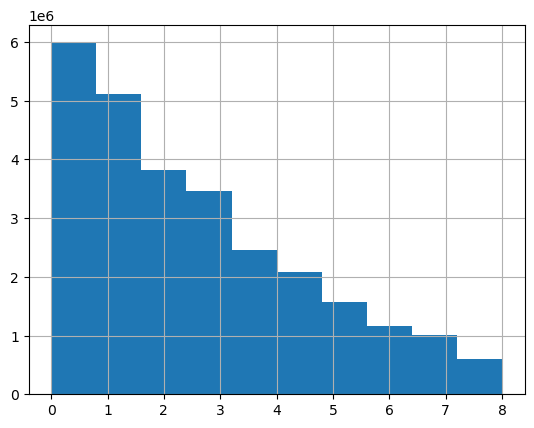

In [4]:
(bureau_balance['MONTHS_BALANCE'] / -12.0).hist()
plt.show()

In [5]:
# filter here for looking up balance within 1, 2, 3 years
bureau_balance["MONTHS_BALANCE"] = bureau_balance["MONTHS_BALANCE"] / -12
# bureau_balance = bureau_balance[(bureau_balance["MONTHS_BALANCE"] >= 1) & (bureau_balance["MONTHS_BALANCE"] < 1)]
# bureau_balance = bureau_balance[(bureau_balance["MONTHS_BALANCE"] >= 2) & (bureau_balance["MONTHS_BALANCE"] < 3)]
# bureau_balance = bureau_balance[bureau_balance["MONTHS_BALANCE"] >= 3]
# bureau_balance = bureau_balance[bureau_balance["MONTHS_BALANCE"] < 1]
bureau_balance.head()  # filter

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,-0.0000,C
1,5715448,0.0833,C
2,5715448,0.1667,C
3,5715448,0.2500,C
4,5715448,0.3333,C


In [6]:
bureau_balance['STATUS'].value_counts(dropna=False)

C    13646993
0    7499507 
X    5810482 
1    242347  
5    62406   
2    23419   
3    8924    
4    5847    
Name: STATUS, dtype: int64

In [7]:
# status 0 means no date past due (không trễ hạn)
# status in (1, 2, 3, 4) is DPD (date past due)
# 5 is sold 
bureau_balance.loc[bureau_balance['STATUS'].isin(['1','2','3','4']), 'STATUS'] = 'DPD'
bureau_balance.loc[bureau_balance['STATUS'] == '5', 'STATUS'] = 'Sold'
bureau_balance['STATUS'].value_counts()

C       13646993
0       7499507 
X       5810482 
DPD     280537  
Sold    62406   
Name: STATUS, dtype: int64

In [8]:
%%time
dict_onehot = {'STATUS' : ['C', '0', 'X', 'DPD', 'Sold'],}
df_onehot = gen_one_hot_feat(bureau_balance, dict_onehot, main_key='SK_ID_BUREAU')

print(df_onehot.shape)
df_onehot.head()

(27299925, 6)
Wall time: 45 s


,SK_ID_BUREAU,STATUS_C,STATUS_0,STATUS_X,STATUS_DPD,STATUS_Sold
0,5715448,1,0,0,0,0
1,5715448,1,0,0,0,0
2,5715448,1,0,0,0,0
3,5715448,1,0,0,0,0
4,5715448,1,0,0,0,0


In [9]:
%%time
df_idata01 = agg_common_data(df_onehot, ["max", "sum", "mean", "std"], main_key="SK_ID_BUREAU")
df_idata01.head()

{'STATUS_C': ['max', 'sum', 'mean', 'std'],
 'STATUS_0': ['max', 'sum', 'mean', 'std'],
 'STATUS_X': ['max', 'sum', 'mean', 'std'],
 'STATUS_DPD': ['max', 'sum', 'mean', 'std'],
 'STATUS_Sold': ['max', 'sum', 'mean', 'std']}

After agg: (817395, 20)
Wall time: 6.1 s


,STATUS_C_max,STATUS_C_sum,STATUS_C_mean,STATUS_C_std,STATUS_0_max,STATUS_0_sum,STATUS_0_mean,STATUS_0_std,STATUS_X_max,STATUS_X_sum,STATUS_X_mean,STATUS_X_std,STATUS_DPD_max,STATUS_DPD_sum,STATUS_DPD_mean,STATUS_DPD_std,STATUS_Sold_max,STATUS_Sold_sum,STATUS_Sold_mean,STATUS_Sold_std
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,
5001709,1,86,0.8866,0.3187,0,0,0.0000,0.0000,1,11,0.1134,0.3187,0,0,0.0,0.0,0,0,0.0,0.0
5001710,1,48,0.5783,0.4968,1,5,0.0602,0.2394,1,30,0.3614,0.4833,0,0,0.0,0.0,0,0,0.0,0.0
5001711,0,0,0.0000,0.0000,1,3,0.7500,0.5000,1,1,0.2500,0.5000,0,0,0.0,0.0,0,0,0.0,0.0
5001712,1,9,0.4737,0.5130,1,10,0.5263,0.5130,0,0,0.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0
5001713,0,0,0.0000,0.0000,0,0,0.0000,0.0000,1,22,1.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0


In [10]:
# số transaction của từng id bureau
df_idata02 = bureau_balance.groupby("SK_ID_BUREAU").size().to_frame("bureau_num_trans")
df_idata02.head()

,bureau_num_trans
SK_ID_BUREAU,
5001709,97
5001710,83
5001711,4
5001712,19
5001713,22


In [11]:
df_idata = df_idata01.join(df_idata02).reset_index()
df_idata.head()

,SK_ID_BUREAU,STATUS_C_max,STATUS_C_sum,STATUS_C_mean,STATUS_C_std,STATUS_0_max,STATUS_0_sum,STATUS_0_mean,STATUS_0_std,STATUS_X_max,STATUS_X_sum,STATUS_X_mean,STATUS_X_std,STATUS_DPD_max,STATUS_DPD_sum,STATUS_DPD_mean,STATUS_DPD_std,STATUS_Sold_max,STATUS_Sold_sum,STATUS_Sold_mean,STATUS_Sold_std,bureau_num_trans
0,5001709,1,86,0.8866,0.3187,0,0,0.0000,0.0000,1,11,0.1134,0.3187,0,0,0.0,0.0,0,0,0.0,0.0,97
1,5001710,1,48,0.5783,0.4968,1,5,0.0602,0.2394,1,30,0.3614,0.4833,0,0,0.0,0.0,0,0,0.0,0.0,83
2,5001711,0,0,0.0000,0.0000,1,3,0.7500,0.5000,1,1,0.2500,0.5000,0,0,0.0,0.0,0,0,0.0,0.0,4
3,5001712,1,9,0.4737,0.5130,1,10,0.5263,0.5130,0,0,0.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0,19
4,5001713,0,0,0.0000,0.0000,0,0,0.0000,0.0000,1,22,1.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0,22


# Feature Engineering

In [12]:
# Join application to bureau balance
df_ids = pd.concat([application_train[["SK_ID_CURR"]], application_test[["SK_ID_CURR"]]])

df_data = (df_ids.merge(bureau[["SK_ID_CURR", "SK_ID_BUREAU"]], on="SK_ID_CURR")
            .merge(df_idata, on="SK_ID_BUREAU"))

print(df_data.shape)
df_data.head()

(523515, 23)


,SK_ID_CURR,SK_ID_BUREAU,STATUS_C_max,STATUS_C_sum,STATUS_C_mean,STATUS_C_std,STATUS_0_max,STATUS_0_sum,STATUS_0_mean,STATUS_0_std,STATUS_X_max,STATUS_X_sum,STATUS_X_mean,STATUS_X_std,STATUS_DPD_max,STATUS_DPD_sum,STATUS_DPD_mean,STATUS_DPD_std,STATUS_Sold_max,STATUS_Sold_sum,STATUS_Sold_mean,STATUS_Sold_std,bureau_num_trans
0,219374,5576630,1,26,0.7222,0.4543,1,10,0.2778,0.4543,0,0,0.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0,36
1,219374,5576632,1,26,0.7222,0.4543,1,10,0.2778,0.4543,0,0,0.0000,0.0000,0,0,0.0,0.0,0,0,0.0,0.0,36
2,159669,5832095,0,0,0.0000,0.0000,1,16,0.9412,0.2425,1,1,0.0588,0.2425,0,0,0.0,0.0,0,0,0.0,0.0,17
3,159669,5832096,0,0,0.0000,0.0000,1,16,0.9412,0.2425,1,1,0.0588,0.2425,0,0,0.0,0.0,0,0,0.0,0.0,17
4,205758,5038523,0,0,0.0000,0.0000,1,17,0.8947,0.3153,1,2,0.1053,0.3153,0,0,0.0,0.0,0,0,0.0,0.0,19


In [13]:
# statistics on status_sum, bureau_num_trans
list_cols = [cname for cname in df_data.columns if '_sum' in cname] + ['bureau_num_trans']
df_stats = df_data[['SK_ID_CURR'] + list_cols]
df_stats.head()

,SK_ID_CURR,STATUS_C_sum,STATUS_0_sum,STATUS_X_sum,STATUS_DPD_sum,STATUS_Sold_sum,bureau_num_trans
0,219374,26,10,0,0,0,36
1,219374,26,10,0,0,0,36
2,159669,0,16,1,0,0,17
3,159669,0,16,1,0,0,17
4,205758,0,17,2,0,0,19


In [14]:
df_agg01 = agg_common_data(df_stats, ls_func=["min", "max", "mean", "std", "median"])
df_agg01.head()

{'STATUS_C_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_0_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_X_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_DPD_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_Sold_sum': ['min', 'max', 'mean', 'std', 'median'],
 'bureau_num_trans': ['min', 'max', 'mean', 'std', 'median']}

After agg: (92231, 30)


,STATUS_C_sum_min,STATUS_C_sum_max,STATUS_C_sum_mean,STATUS_C_sum_std,STATUS_C_sum_median,STATUS_0_sum_min,STATUS_0_sum_max,STATUS_0_sum_mean,STATUS_0_sum_std,STATUS_0_sum_median,STATUS_X_sum_min,STATUS_X_sum_max,STATUS_X_sum_mean,STATUS_X_sum_std,STATUS_X_sum_median,STATUS_DPD_sum_min,STATUS_DPD_sum_max,STATUS_DPD_sum_mean,STATUS_DPD_sum_std,STATUS_DPD_sum_median,STATUS_Sold_sum_min,STATUS_Sold_sum_max,STATUS_Sold_sum_mean,STATUS_Sold_sum_std,STATUS_Sold_sum_median,bureau_num_trans_min,bureau_num_trans_max,bureau_num_trans_mean,bureau_num_trans_std,bureau_num_trans_median
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,44,44,44.0000,NaN,44.0,10,10,10.0000,NaN,10.0,0,0,0.0000,NaN,0.0,0,0,0.0,NaN,0.0,0,0,0.0,NaN,0.0,54,54,54.0000,NaN,54.0
5,0,32,3.9091,9.8839,0.0,0,10,4.0909,3.0807,3.0,0,24,5.6364,7.0466,3.0,0,0,0.0,0.0000,0.0,0,0,0.0,0.0000,0.0,3,56,13.6364,15.6094,9.0
8,0,61,30.5000,43.1335,30.5,3,8,5.5000,3.5355,5.5,0,1,0.5000,0.7071,0.5,0,3,1.5,2.1213,1.5,0,12,6.0,8.4853,6.0,4,84,44.0000,56.5685,44.0
11,0,72,27.6000,29.8001,20.5,1,29,10.6000,9.0333,9.5,0,4,1.5000,1.7795,1.0,0,5,0.7,1.6364,0.0,0,0,0.0,0.0000,0.0,8,78,40.4000,28.6209,31.5
13,0,66,29.5000,29.5306,22.5,2,8,6.5000,2.1731,8.0,0,20,3.6000,5.7966,2.0,0,0,0.0,0.0000,0.0,0,0,0.0,0.0000,0.0,4,76,39.6000,29.9526,35.0


In [15]:
eval_agg01 = feature_evaluate(application_train_filtered, df_agg01.reset_index())
eval_agg01

,name,auc,corr,coverage
27,bureau_num_trans_mean,0.5933,-0.0794,1.0000
29,bureau_num_trans_median,0.5908,-0.0757,1.0000
25,bureau_num_trans_min,0.5727,-0.0476,1.0000
2,STATUS_C_sum_mean,0.5726,-0.0617,1.0000
26,bureau_num_trans_max,0.5723,-0.0665,1.0000
4,STATUS_C_sum_median,0.5651,-0.0568,1.0000
1,STATUS_C_sum_max,0.5622,-0.0580,1.0000
3,STATUS_C_sum_std,0.5592,-0.0540,0.8688
28,bureau_num_trans_std,0.5506,-0.0454,0.8688
17,STATUS_DPD_sum_mean,0.5466,0.0335,1.0000


In [16]:
# keep binary vlues
list_cols = [cname for cname in df_data.columns if '_max' in cname]
df_binary = df_data[['SK_ID_CURR'] + list_cols]
df_binary.head()

,SK_ID_CURR,STATUS_C_max,STATUS_0_max,STATUS_X_max,STATUS_DPD_max,STATUS_Sold_max
0,219374,1,1,0,0,0
1,219374,1,1,0,0,0
2,159669,0,1,1,0,0
3,159669,0,1,1,0,0
4,205758,0,1,1,0,0


In [17]:
df_agg02 = agg_common_data(df_binary, ['max'])
df_agg02.head()

{'STATUS_C_max': ['max'],
 'STATUS_0_max': ['max'],
 'STATUS_X_max': ['max'],
 'STATUS_DPD_max': ['max'],
 'STATUS_Sold_max': ['max']}

After agg: (92231, 5)


,STATUS_C_max_max,STATUS_0_max_max,STATUS_X_max_max,STATUS_DPD_max_max,STATUS_Sold_max_max
SK_ID_CURR,,,,,
1,1,1,0,0,0
5,1,1,1,0,0
8,1,1,1,1,1
11,1,1,1,1,0
13,1,1,1,0,0


In [18]:
eval_agg02 = feature_evaluate(application_train_filtered, df_agg02.reset_index())
display(eval_agg02)

,name,auc,corr,coverage
3,STATUS_DPD_max_max,0.5425,0.0495,1.0
0,STATUS_C_max_max,0.5278,-0.0382,1.0
4,STATUS_Sold_max_max,0.5045,0.0161,1.0
2,STATUS_X_max_max,0.5015,0.0021,1.0
1,STATUS_0_max_max,0.5008,0.0027,1.0


# Save Features

In [19]:

df_feat = df_agg01.join(df_agg02)
print(df_feat.shape)
df_feat.head()

(92231, 35)


,STATUS_C_sum_min,STATUS_C_sum_max,STATUS_C_sum_mean,STATUS_C_sum_std,STATUS_C_sum_median,STATUS_0_sum_min,STATUS_0_sum_max,STATUS_0_sum_mean,STATUS_0_sum_std,STATUS_0_sum_median,STATUS_X_sum_min,STATUS_X_sum_max,STATUS_X_sum_mean,STATUS_X_sum_std,STATUS_X_sum_median,STATUS_DPD_sum_min,STATUS_DPD_sum_max,STATUS_DPD_sum_mean,STATUS_DPD_sum_std,STATUS_DPD_sum_median,STATUS_Sold_sum_min,STATUS_Sold_sum_max,STATUS_Sold_sum_mean,STATUS_Sold_sum_std,STATUS_Sold_sum_median,bureau_num_trans_min,bureau_num_trans_max,bureau_num_trans_mean,bureau_num_trans_std,bureau_num_trans_median,STATUS_C_max_max,STATUS_0_max_max,STATUS_X_max_max,STATUS_DPD_max_max,STATUS_Sold_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,44,44,44.0000,NaN,44.0,10,10,10.0000,NaN,10.0,0,0,0.0000,NaN,0.0,0,0,0.0,NaN,0.0,0,0,0.0,NaN,0.0,54,54,54.0000,NaN,54.0,1,1,0,0,0
5,0,32,3.9091,9.8839,0.0,0,10,4.0909,3.0807,3.0,0,24,5.6364,7.0466,3.0,0,0,0.0,0.0000,0.0,0,0,0.0,0.0000,0.0,3,56,13.6364,15.6094,9.0,1,1,1,0,0
8,0,61,30.5000,43.1335,30.5,3,8,5.5000,3.5355,5.5,0,1,0.5000,0.7071,0.5,0,3,1.5,2.1213,1.5,0,12,6.0,8.4853,6.0,4,84,44.0000,56.5685,44.0,1,1,1,1,1
11,0,72,27.6000,29.8001,20.5,1,29,10.6000,9.0333,9.5,0,4,1.5000,1.7795,1.0,0,5,0.7,1.6364,0.0,0,0,0.0,0.0000,0.0,8,78,40.4000,28.6209,31.5,1,1,1,1,0
13,0,66,29.5000,29.5306,22.5,2,8,6.5000,2.1731,8.0,0,20,3.6000,5.7966,2.0,0,0,0.0,0.0000,0.0,0,0,0.0,0.0000,0.0,4,76,39.6000,29.9526,35.0,1,1,1,0,0


In [20]:
%%time
fname = "bureau_balance"

fname = os.path.join("features", "{}.pkl.bz2".format(fname))
df_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")

Store features completed!
Wall time: 1.14 s
